In [ ]:
import sys
import numpy as np
import pandas as pd
import os
import math

# dataset fetching
import openml
from ucimlrepo import fetch_ucirepo 

# model selection and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, TimeSeriesSplit, StratifiedKFold
from sklearn.feature_selection import VarianceThreshold, RFE, RFECV
from sklearn.calibration import CalibratedClassifierCV, calibration_curve, CalibrationDisplay
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler, Normalizer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, HistGradientBoostingClassifier, HistGradientBoostingRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC, SVR, LinearSVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import log_loss, accuracy_score, brier_score_loss, roc_auc_score, classification_report, r2_score, mean_squared_error, mean_absolute_error, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score, confusion_matrix
from scipy.stats import uniform, randint
import featuretools as ft
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier


# plotting
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

# conformal prediction libraries
from venn_abers import VennAbersCalibrator, VennAbers


from crepes import WrapClassifier, ConformalClassifier

from nonconformist.nc import NcFactory, InverseProbabilityErrFunc, MarginErrFunc
from nonconformist.cp import TcpClassifier

from mapie.regression import MapieTimeSeriesRegressor
from mapie.metrics import (regression_coverage_score,
                           coverage_width_based,
                           regression_mean_width_score,)
from mapie.subsample import BlockBootstrap


import warnings
warnings.filterwarnings('ignore')


## Sepsis Dataset

,age,max_activity_count,duration_since_reg,crp,lacticacid,leucocytes,diagnose,diagnosticartastrup,diagnosticblood,diagnosticecg,diagnosticic,diagnosticlacticacid,diagnosticliquor,diagnosticother,diagnosticsputum,diagnosticurinaryculture,diagnosticurinarysediment,diagnosticxthorax,resource,disfuncorg,hypotensie,hypoxie,infectionsuspected,infusion,oligurie,sirscritheartrate,sirscritleucos,sirscrittachypnea,sirscrittemperature,sirscriteria2ormore,hours_past_midnight,duration_last_event,CRP => ER Triage,CRP => IV Liquid,CRP => LacticAcid,CRP => Leucocytes,ER Registration => CRP,ER Registration => ER Sepsis Triage,ER Registration => ER Triage,ER Registration => IV Liquid,ER Registration => LacticAcid,ER Registration => Leucocytes,ER Sepsis Triage => ER Triage,ER Sepsis Triage => IV Antibiotics,ER Sepsis Triage => IV Liquid,IV Antibiotics => ER Triage,IV Liquid => ER Sepsis Triage,IV Liquid => ER Triage,IV Liquid => IV Antibiotics,LacticAcid => CRP,LacticAcid => ER Triage,LacticAcid => IV Liquid,LacticAcid => Leucocytes,Leucocytes => CRP,Leucocytes => ER Triage,Leucocytes => IV Liquid,Leucocytes => LacticAcid
0,0.4,3.0,2.034049,210.0,2.2,9.6,0,1,1,1,1,1,0,0,0,1,1,1,0,1,1,0,1,1,0,1,0,1,1,1,-0.445679,-0.071006,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
1,0.0,0.0,-0.673575,0.0,0.0,0.0,142,0,1,1,1,1,0,0,0,1,1,1,0,0,0,0,1,1,0,1,0,1,1,1,-0.717663,-0.224852,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,-0.6,0.0,-0.515174,0.0,0.0,0.0,12,0,1,1,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,1,-1.456699,-0.106509,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.6,0.0,-0.599556,0.0,0.0,0.0,142,1,1,1,1,1,0,0,0,1,1,1,0,0,0,0,1,1,0,1,0,1,1,1,-0.614346,-0.177515,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0.0,0.0,1.096965,0.0,0.0,0.0,116,0,1,1,1,1,0,0,0,1,1,1,0,0,0,0,1,1,0,1,0,0,1,1,-0.431512,-0.130178,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


class distribution in the dataset: [897  98]


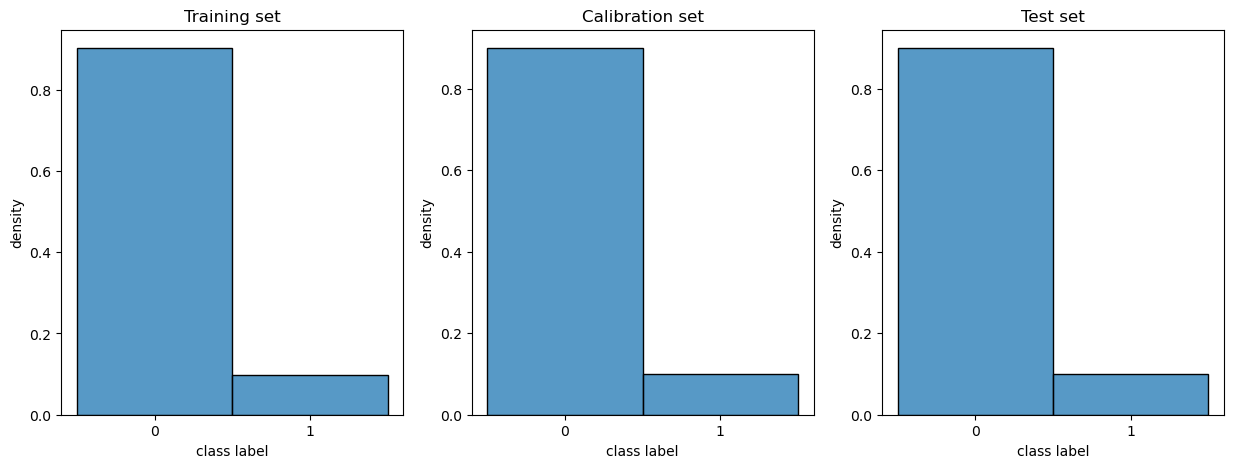

Train set size: (636, 57)
Calibration set size: (160, 57)
Test set size: (199, 57)


In [76]:
# dataset

dataset = pd.read_csv("./dataset/Sepsis_Processed_IC.csv")
X = dataset.drop(columns=['Target'], axis=1)
y = dataset['Target']


# handle datatypes
# drop columns
X.drop(columns=['case_id'], inplace=True)
# convert categorical data to numerical
category_columns = X.select_dtypes(include=['object']).columns
label_encoders = {}
for column in category_columns:
    label_encoders[column] = LabelEncoder()
    X[column] = label_encoders[column].fit_transform(X[column])
# convert bool to int
bool_columns = X.select_dtypes(include=['bool']).columns
for column in bool_columns:
    X[column] = X[column].astype('int')
# convert class labels to numerical
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# standardize the data
scaler = RobustScaler()
scaled_columns = ['age', 'max_activity_count', 'duration_since_reg', 'crp', 'lacticacid', 'hours_past_midnight', 'duration_last_event']
X[scaled_columns] = scaler.fit_transform(X[scaled_columns])

# display dataset
pd.set_option('display.max_columns', None)
display(X.head(5))
print("class distribution in the dataset:", np.bincount(y))

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train_proper, X_cal, y_train_proper, y_cal = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# plot the class distribution in the training set, calibration set and test set
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(y_train_proper, bins=np.arange(3)-0.5, stat='density', ax=ax[0])
sns.histplot(y_cal, bins=np.arange(3)-0.5, stat='density', ax=ax[1])
sns.histplot(y_test, bins=np.arange(3)-0.5, stat='density', ax=ax[2])
for i in range(3):
    ax[i].set_xticks([0, 1])
    ax[i].set_xticklabels(label_encoder.classes_)
    ax[i].set_xlabel('class label')
    ax[i].set_ylabel('density')
ax[0].set_title('Training set')
ax[1].set_title('Calibration set')
ax[2].set_title('Test set')
plt.show()

# print split sizes
print("Train set size:", X_train_proper.shape)
print("Calibration set size:", X_cal.shape)
print("Test set size:", X_test.shape)

## Model Training and Evaluation - HistGradientBoostingClassifier

ROC AUC: 0.81
Average Precision: 0.69


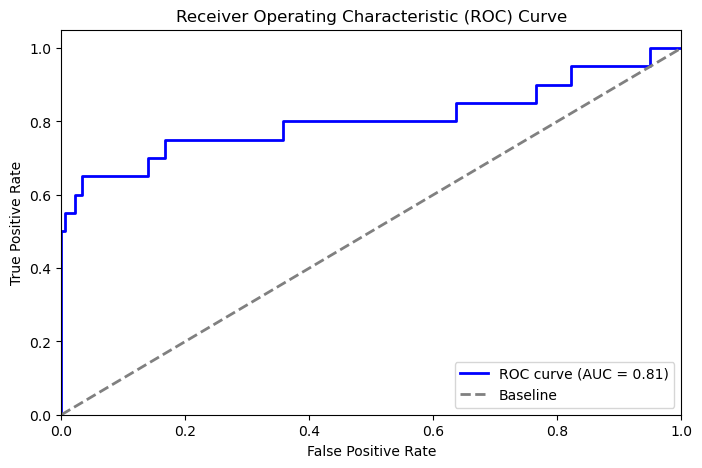

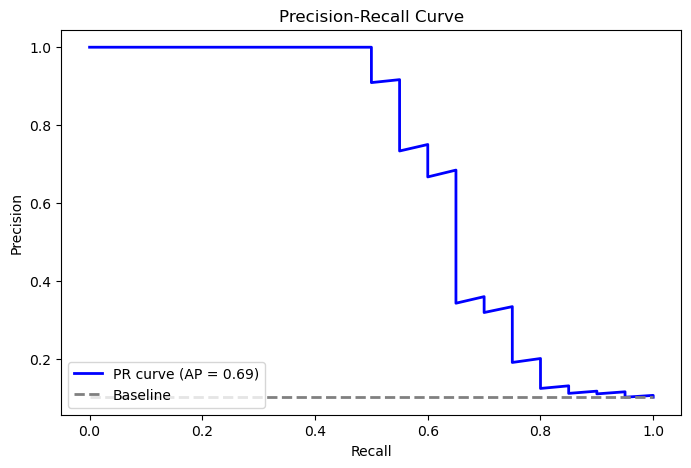

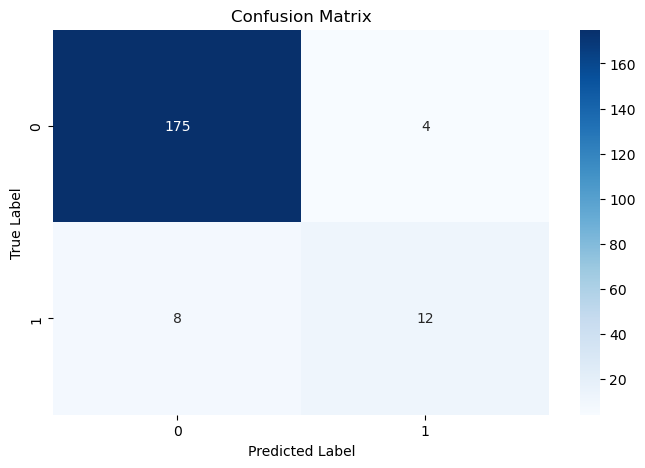

In [77]:
# base model
clf = HistGradientBoostingClassifier(random_state=42, scoring='f1_macro', max_iter=1000, class_weight={0: 1, 1: 6}, learning_rate=0.01)
clf.fit(X_train_proper, y_train_proper)
prediction_prob_test = clf.predict_proba(X_test)
predictions = clf.predict(X_test)

# evaluation
roc_auc = roc_auc_score(y_test, prediction_prob_test[:,1])
print(f"ROC AUC: {roc_auc:.2f}")
average_precision = average_precision_score(y_test, prediction_prob_test[:,1])
print(f"Average Precision: {average_precision:.2f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, prediction_prob_test[:,1])
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Baseline')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# plot precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, prediction_prob_test[:, 1])
baseline = len(y_test[y_test==1]) / len(y_test) # ratio of positive class
plt.figure(figsize=(8, 5))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AP = {average_precision:.2f})')
plt.plot([0, 1], [baseline, baseline], color='gray', lw=2, linestyle='--', label='Baseline')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

# confusion matrix
# threshold = 0.1
# predictions = (prediction_prob_test[:, 1] >= threshold).astype(int)
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

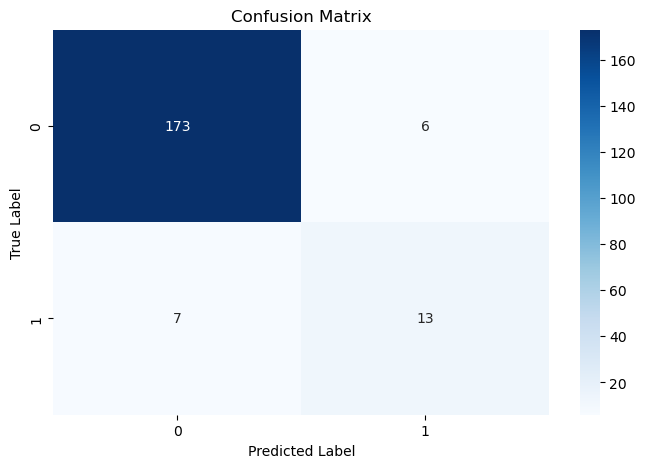

In [78]:
threshold = 0.3
predictions = (prediction_prob_test[:, 1] >= threshold).astype(int)
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### Unceartainty Estimation

#### Crepes Library - Inductive Conformal Prediction

Coverage: 0.88
Average Set Width: 0.92


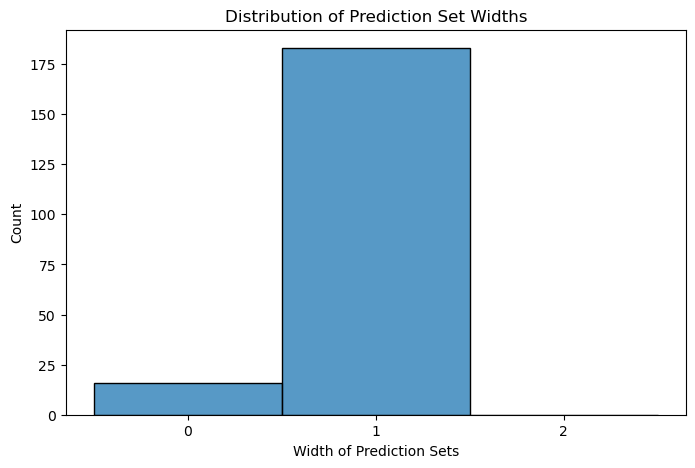

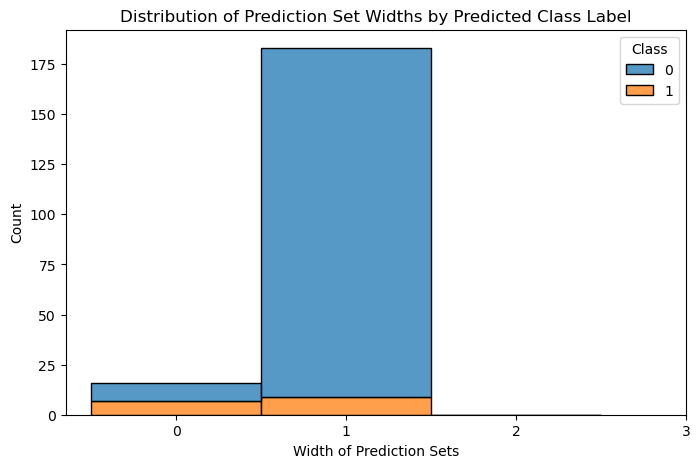

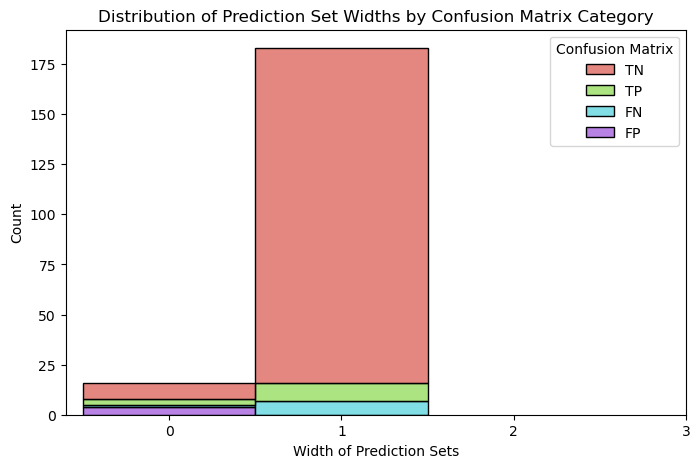

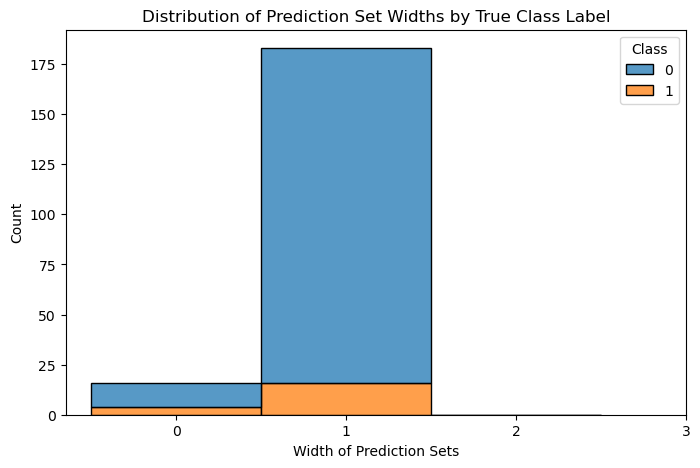

Indices where width is 0:  [10, 15, 37, 46, 55, 61, 64, 108, 117, 128, 131, 143, 146, 173, 176, 186]
Indices where width is 2:  []


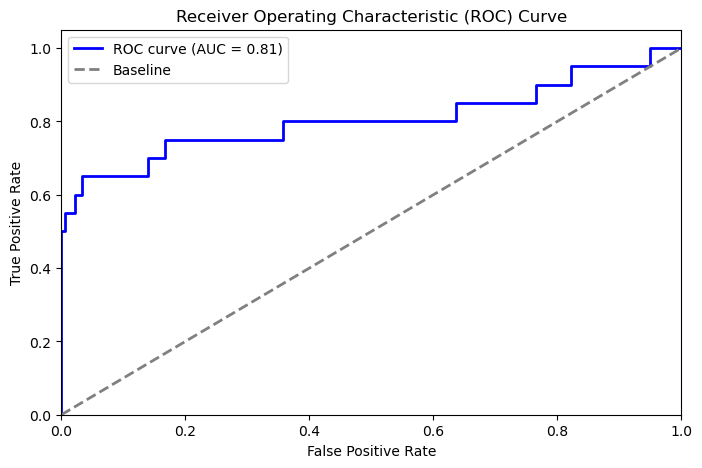

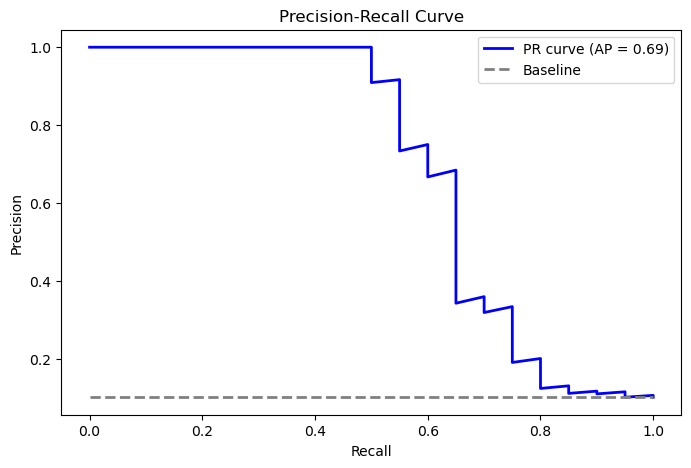

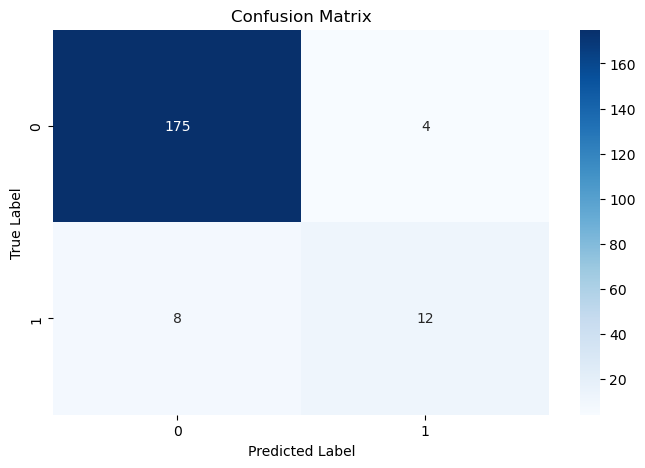

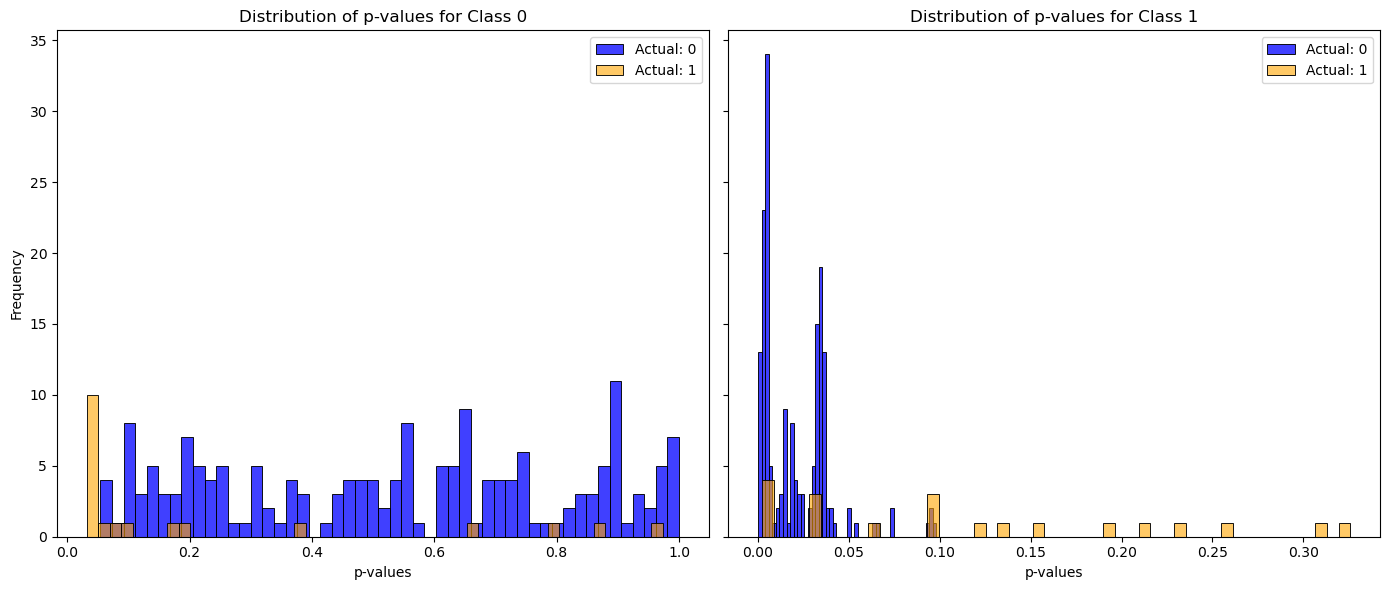

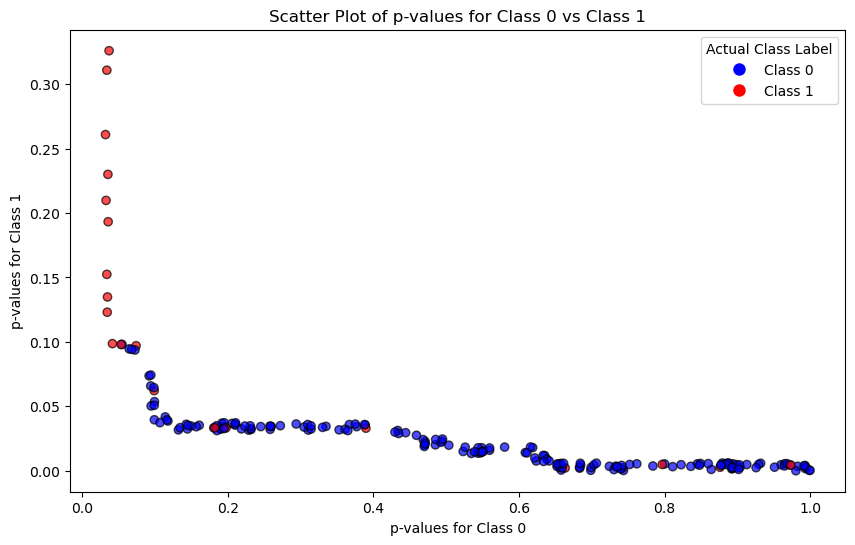

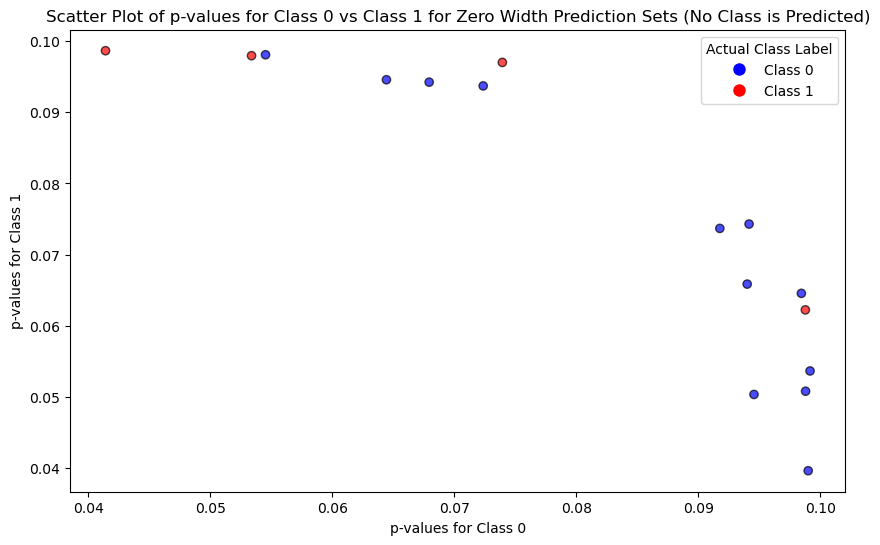

In [149]:
wrapped_clf = WrapClassifier(clf)

wrapped_clf.calibrate(X_cal, y_cal)

prediction_sets = wrapped_clf.predict_set(X_test, confidence=0.9) # significance level 0.1
predictions = wrapped_clf.predict(X_test)
prediction_prob_test = wrapped_clf.predict_proba(X_test)
prediction_p_values = wrapped_clf.predict_p(X_test)

# print("1st output of prediction_sets: ",prediction_sets[0])
# print(prediction_sets.shape)


# evaluation
coverage = np.mean([prediction_sets[i][y_test[i]] for i in range(len(prediction_sets))])
widths = [np.sum(pred) for pred in prediction_sets]
average_width = np.mean(widths)

print(f"Coverage: {coverage:.2f}")
print(f"Average Set Width: {average_width:.2f}")

# result = wrapped_clf.evaluate(X_test, y_test, confidence=0.9)
# print(result)
# print(classification_report(y_test, predictions))

# Plot distribution of predictive set sizes
plt.figure(figsize=(8, 5))
sns.histplot(widths, bins=np.arange(0, 4) - 0.5, edgecolor='black', kde=False, palette='tab10')
plt.xticks([0, 1, 2])
plt.xlabel('Width of Prediction Sets')
plt.ylabel('Count')
plt.title('Distribution of Prediction Set Widths')
plt.show()

# plot prediction set widths by predicted class label
data = {'widths': widths, 'Class': predictions}
data_df = pd.DataFrame(data)
plt.figure(figsize=(8, 5))
sns.histplot(data=data_df, x='widths', hue='Class', bins=np.arange(0, 4) - 0.5, edgecolor='black', kde=False, palette='tab10', multiple='stack')
plt.xticks([0, 1, 2, 3])
plt.xlabel('Width of Prediction Sets')
plt.ylabel('Count')
plt.title('Distribution of Prediction Set Widths by Predicted Class Label')
plt.show()


# plot prediction set widths by confusion matrix category
cm_labels = []
for true, pred in zip(y_test, predictions):
    if true == 1 and pred == 1:
        cm_labels.append('TP')  # True Positive
    elif true == 0 and pred == 0:
        cm_labels.append('TN')  # True Negative
    elif true == 0 and pred == 1:
        cm_labels.append('FP')  # False Positive
    elif true == 1 and pred == 0:
        cm_labels.append('FN')  # False Negative
data = {'widths': widths, 'Confusion Matrix': cm_labels}
data_df = pd.DataFrame(data)
plt.figure(figsize=(8, 5))
sns.histplot(data=data_df, x='widths', hue='Confusion Matrix', multiple='stack', discrete=True, bins=np.arange(0, 4) - 0.5, edgecolor='black', kde=False, palette='hls')
plt.xticks([0, 1, 2, 3])
plt.xlabel('Width of Prediction Sets')
plt.ylabel('Count')
plt.title('Distribution of Prediction Set Widths by Confusion Matrix Category')
plt.show()


# plot prediction set widths by true class label
data = {'widths': widths, 'Class': y_test}
data_df = pd.DataFrame(data)
plt.figure(figsize=(8, 5))
sns.histplot(data=data_df, x='widths', hue='Class', bins=np.arange(0, 4) - 0.5, edgecolor='black', kde=False, palette='tab10', multiple='stack')
plt.xticks([0, 1, 2, 3])
plt.xlabel('Width of Prediction Sets')
plt.ylabel('Count')
plt.title('Distribution of Prediction Set Widths by True Class Label')
plt.show()

# indices in predictions where width is 0
zero_width_indices_crepes = [i for i in range(len(prediction_sets)) if np.sum(prediction_sets[i]) == 0]
print("Indices where width is 0: ",zero_width_indices_crepes)

# indices in predictions where width is 2
two_width_indices_crepes = [i for i in range(len(prediction_sets)) if np.sum(prediction_sets[i]) == 2]
print("Indices where width is 2: ",two_width_indices_crepes)


# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, prediction_prob_test[:,1])
roc_auc = roc_auc_score(y_test, prediction_prob_test[:,1])
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Baseline')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='best')
plt.show()

# plot precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, prediction_prob_test[:, 1])
average_precision = average_precision_score(y_test, prediction_prob_test[:, 1])
baseline = len(y_test[y_test==1]) / len(y_test) # ratio of positive class
plt.figure(figsize=(8, 5))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AP = {average_precision:.2f})')
plt.plot([0, 1], [baseline, baseline], color='gray', lw=2, linestyle='--', label='Baseline')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()

# confusion matrix
# threshold = 0.1
# predictions = (prediction_prob_test[:, 1] >= threshold).astype(int)
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# plot p_values distribution for each class label in the test set with actual class labels
class_0_p_values = prediction_p_values[:, 0]
class_1_p_values = prediction_p_values[:, 1]
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
# Plot distribution of p-values for class 0 with actual labels
sns.histplot(class_0_p_values[y_test == 0], bins=50, color='blue', kde=False, ax=axes[0], label='Actual: 0')
sns.histplot(class_0_p_values[y_test == 1], bins=50, color='orange', kde=False, ax=axes[0], label='Actual: 1', alpha=0.6)
axes[0].set_title('Distribution of p-values for Class 0')
axes[0].set_xlabel('p-values')
axes[0].set_ylabel('Frequency')
axes[0].legend()
# Plot distribution of p-values for class 1 with actual labels
sns.histplot(class_1_p_values[y_test == 0], bins=50, color='blue', kde=False, ax=axes[1], label='Actual: 0')
sns.histplot(class_1_p_values[y_test == 1], bins=50, color='orange', kde=False, ax=axes[1], label='Actual: 1', alpha=0.6)
axes[1].set_title('Distribution of p-values for Class 1')
axes[1].set_xlabel('p-values')
axes[1].legend()
plt.tight_layout()
plt.show()

# scatter plot of p-values for class 0 vs class 1 with actual class labels
class_0_p_values = prediction_p_values[:, 0]
class_1_p_values = prediction_p_values[:, 1]
colors = ['blue' if label == 0 else 'red' for label in y_test]
plt.figure(figsize=(10, 6))
plt.scatter(class_0_p_values, class_1_p_values, c=colors, alpha=0.7, edgecolors='k')
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Class 0'),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Class 1')]
plt.legend(handles=handles, title='Actual Class Label')
plt.xlabel('p-values for Class 0')
plt.ylabel('p-values for Class 1')
plt.title('Scatter Plot of p-values for Class 0 vs Class 1')
plt.show()

if len(zero_width_indices_crepes) > 0:
    # scatter plot of p-values for class 0 vs class 1 with actual class labels for zero width prediction sets
    zero_width_class_0_p_values = class_0_p_values[zero_width_indices_crepes]
    zero_width_class_1_p_values = class_1_p_values[zero_width_indices_crepes]
    y_test_zero_width = y_test[zero_width_indices_crepes]
    colors = ['blue' if label == 0 else 'red' for label in y_test_zero_width]
    plt.figure(figsize=(10, 6))
    plt.scatter(zero_width_class_0_p_values, zero_width_class_1_p_values, c=colors, alpha=0.7, edgecolors='k')
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Class 0'),
               plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Class 1')]
    plt.legend(handles=handles, title='Actual Class Label')
    plt.xlabel('p-values for Class 0')
    plt.ylabel('p-values for Class 1')
    plt.title('Scatter Plot of p-values for Class 0 vs Class 1 for Zero Width Prediction Sets (No Class is Predicted)')
    plt.show()

#### Venn Abers Calibration

,p0,p1,p of class_1,y
0,0.058824,0.166667,0.150442,0
1,0.058824,0.070588,0.069767,0
2,0.058824,0.070588,0.069767,0
3,0.058824,0.070588,0.069767,0
4,0.750000,1.000000,0.800000,1
5,0.058824,0.100000,0.096045,0
6,0.000000,0.019608,0.019231,0
7,0.000000,0.069767,0.065217,0
8,0.000000,0.027778,0.027027,0
9,0.058824,0.100000,0.096045,0


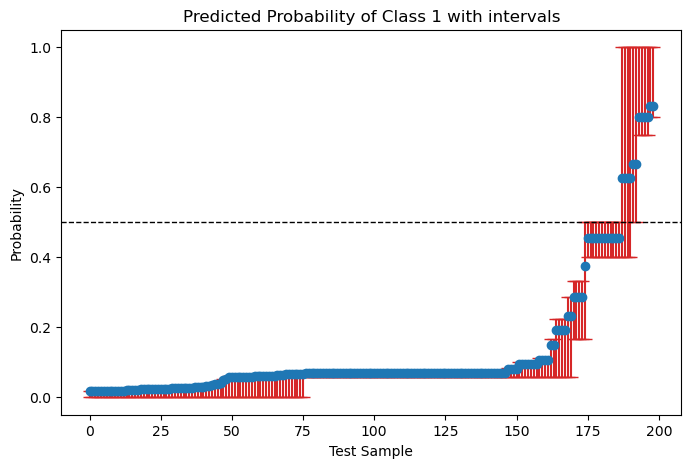

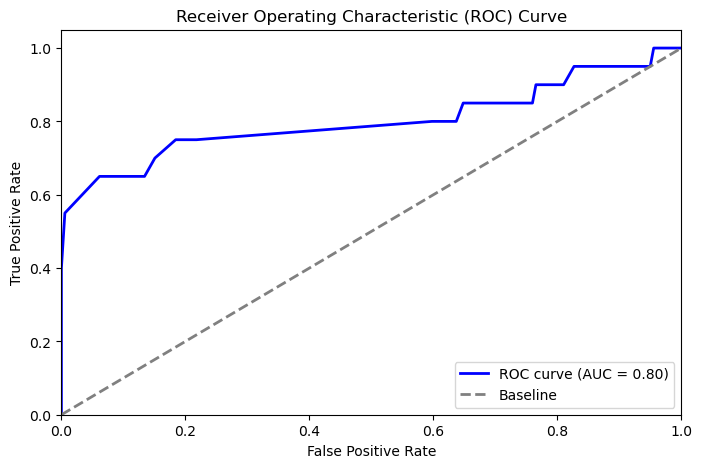

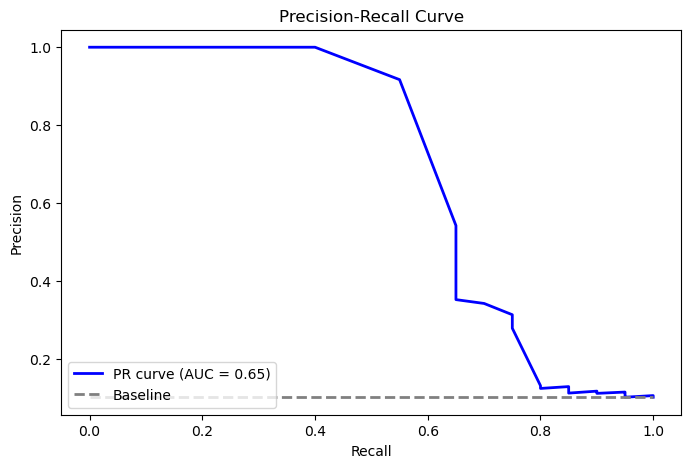

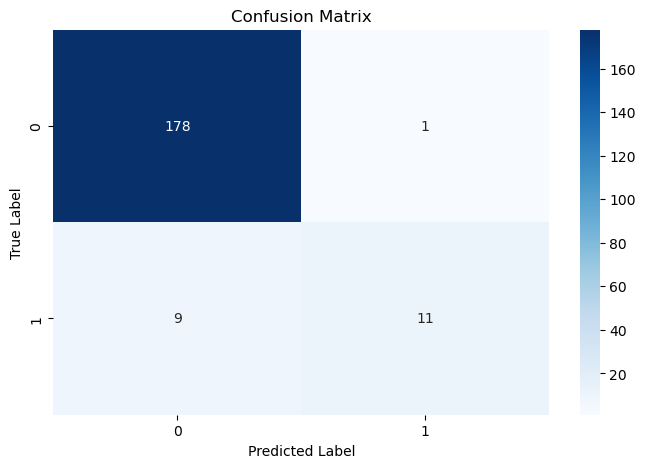

In [80]:
prediction_prob_cal = clf.predict_proba(X_cal)
prediction_prob_test = clf.predict_proba(X_test)
y_pred_noncal = clf.predict(X_test)

va = VennAbersCalibrator()
p_prime = va.predict_proba(p_cal=prediction_prob_cal, y_cal=y_cal, p_test=prediction_prob_test, p0_p1_output=True) # probability intervals for class 1
y_pred = va.predict(p_cal=prediction_prob_cal, y_cal=y_cal, p_test=prediction_prob_test) # predicted class labels

# convert to class labels
y_pred = np.argmax(y_pred, axis=1)

# evaluation
# coverage = np.mean([p_prime[0][i][y_test[i]] <= p_prime[1][i][y_test[i]] for i in range(len(y_test))])
# print(f"Coverage: {coverage:.2f}")
# print(classification_report(y_test, y_pred))


# plot prediction probabilities with intervals
y_pred_interval_p1 = p_prime[1]
y_pred_p1 = p_prime[0][:, 1]

# create dataframe using p0 and p1
df = pd.DataFrame({'p0': y_pred_interval_p1[:,0], 'p1': y_pred_interval_p1[:,1], 'p of class_1': y_pred_p1, 'y': y_test})
display(df.head(10))


# sort the predicted probabilities
sorted_indices = np.argsort(y_pred_p1)
y_pred_interval_p1 = y_pred_interval_p1[sorted_indices]
y_pred_p1 = y_pred_p1[sorted_indices]
y_test_sorted = y_test[sorted_indices]
y_pred_sorted = y_pred[sorted_indices]
lower_bound = y_pred_p1 - y_pred_interval_p1[:, 0]
upper_bound = y_pred_interval_p1[:, 1] - y_pred_p1
bounds = [lower_bound, upper_bound]

plt.figure(figsize=(8, 5))
plt.errorbar(np.arange(len(y_pred_p1)), y_pred_p1, yerr=bounds, fmt='o', ecolor='tab:red', capsize=5, label='Predicted Probability of Class 1')
# plt.scatter(np.arange(len(y_pred_p1)), y_test_sorted, color='tab:blue', label='Actual Label')
plt.axhline(y=0.5, color='black', linestyle='--', linewidth=1)
plt.ylabel('Probability')
plt.xlabel('Test Sample')
plt.title('Predicted Probability of Class 1 with intervals')
# plt.legend()
plt.show()

# plot roc curve
fpr, tpr, _ = roc_curve(y_test_sorted, y_pred_p1)
roc_auc = roc_auc_score(y_test_sorted, y_pred_p1)
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Baseline')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# plot precision-recall curve
baseline = len(y_test_sorted[y_test_sorted==1]) / len(y_test_sorted) # ratio of positive class
precision, recall, _ = precision_recall_curve(y_test_sorted, y_pred_p1)
average_precision = average_precision_score(y_test_sorted, y_pred_p1)
plt.figure(figsize=(8, 5))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AUC = {average_precision:.2f})')
plt.plot([0, 1], [baseline, baseline], color='gray', lw=2, linestyle='--', label='Baseline')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

# confusion matrix
# threshold = 0.5
# predictions = (y_pred_p1 >= threshold).astype(int)
cm = confusion_matrix(y_test_sorted, y_pred_sorted)
plt.figure(figsize=(8, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()